<a href="https://colab.research.google.com/github/tatv047/Data-Science/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

link to lesson: https://www.kaggle.com/code/hamelg/python-for-data-28-logistic-regression

 In this lesson we will learn how to use a common classification technique known as logistic regression and apply it to the Titanic survival data.

 ## Logistic Regression Basics

 Logistic regression is a classification method built on the same concept as linear regression. With linear regression, we take linear combination of explanatory variables plus an intercept term to arrive at a prediction. For example, last time, our simplest linear regression model was:

 $$mileage = intercept + constant*CarWeight$$

Linear regression determines which constants minimize the error this linear combination produces on the input data. In classification problems, the response variable is categorical. The simplest case of classification is where the response variable is binary, meaning it can only take one of two values, such as true or false. Logistic regression takes a linear combination of explanatory variables plus an intercept term just like linear regression, but then it takes the result and passes it through a "logistic" function. The logistic or sigmoid function used for logistic regression is defined as:

$$S(t) = \frac{1}{ 1 + e^{-t}}$$

where t is the same linear combination of variables used in linear regression. The sigmoid function looks like an elongated S when plotted:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

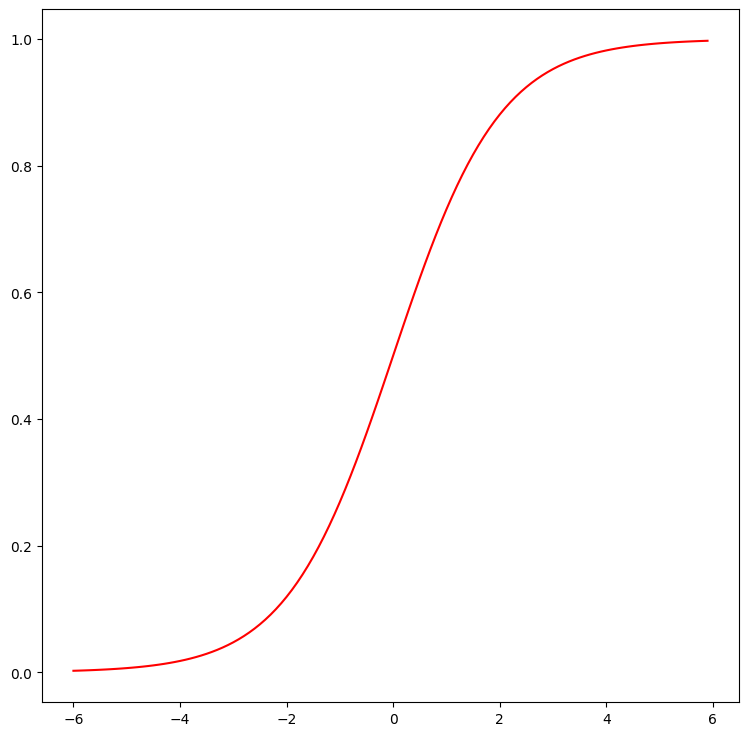

In [2]:
plt.figure(figsize=(9,9))

def sigmoid(t):                          # Define the sigmoid function
    return (1/(1 + np.e**(-t)))

plot_range = np.arange(-6, 6, 0.1)

y_values = sigmoid(plot_range)

# Plot curve
plt.plot(plot_range,   # X-axis range
         y_values,          # Predicted values
         color="red");

The sigmoid function is bounded below by 0 and bounded above by 1. In logistic regression, the output is interpreted as a probability: the probability that an observation belongs to the second of the two categories being modeled. When the linear combination of variables produces positive numbers, the resulting probability is greater than 0.5 and when it produces negative numbers, the probability is less than 0.5.

We won't go deeper into the details behind how logistic regression works, but instead focus on how to use it in Python. The most important thing to know is that logistic regression outputs probabilities that we can use to classify observations.

## Revisting the Titanic

For the remainder of the lesson we'll be working with the Titanic survival training data from Kaggle that we saw in lesson 14. We'll start by loading the data and then carrying out a few of the same preprocessing tasks we did in lesson 14:

In [3]:
titanic_train = pd.read_csv("/content/sample_data/train.csv")    # Read the data

char_cabin = titanic_train["Cabin"].astype(str)     # Convert cabin to str

new_Cabin = np.array([cabin[0] for cabin in char_cabin]) # Take first letter

titanic_train["Cabin"] = pd.Categorical(new_Cabin)  # Save the new cabin var

# Impute median Age for NA Age values
new_age_var = np.where(titanic_train["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_train["Age"])     # Value if check is false

titanic_train["Age"] = new_age_var

new_fare_var = np.where(titanic_train["Fare"].isnull(), # Logical check
                       50,                         # Value if check is true
                       titanic_train["Fare"])     # Value if check is false

titanic_train["Fare"] = new_fare_var

Now we are ready to use a logistic regression model to predict survival. The scikit-learn library has a logistic regression function in the learn model subfolder. Let's make a logistic regression model that only uses the Sex variable as a predictor. Before creating a model with the sex variable, we need to convert to a real number because sklearn's machine learning functions only deal with real numbers. We can convert a categorical variable like into a number using the sklearn preprocessing function LabelEncoder():

In [4]:
from sklearn import linear_model
from sklearn import preprocessing

In [5]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
encoded_sex = label_encoder.fit_transform(titanic_train["Sex"])

# Initialize logistic regression model
log_model = linear_model.LogisticRegression(solver = 'lbfgs')

# Train the model
log_model.fit(X = pd.DataFrame(encoded_sex),
              y = titanic_train["Survived"])

# Check trained model intercept
print(log_model.intercept_)

# Check trained model coefficients
print(log_model.coef_)

[1.01628767]
[[-2.44597988]]


The logistic regression model coefficients look similar to the output we saw for linear regression. We can see the model produced a positive intercept value and a weight of -2.421 on gender. Let's use the model to make predictions on the test set:

In [6]:
# Make predictions
preds = log_model.predict_proba(X= pd.DataFrame(encoded_sex))
preds = pd.DataFrame(preds)
preds.columns = ["Death_prob", "Survival_prob"]

# Generate table of predictions vs Sex
pd.crosstab(titanic_train["Sex"], preds.loc[:, "Survival_prob"])

Survival_prob,0.193147,0.734249
Sex,,
female,0,314
male,577,0


Note: Use model.predict_proba() to get the predicted class probabilities. Use model.predict() to get the predicted classes.

The table shows that the model predicted a survival chance of roughly 19% for males and 73% for females. If we used this simple model to predict survival, we'd end up predicting that all women survived and that all men died. Let's make a more complicated model that includes a few more variables from the titanic training set:

In [7]:
# Convert more variables to numeric
encoded_class = label_encoder.fit_transform(titanic_train["Pclass"])
encoded_cabin = label_encoder.fit_transform(titanic_train["Cabin"])

train_features = pd.DataFrame([encoded_class,
                              encoded_cabin,
                              encoded_sex,
                              titanic_train["Age"]]).T

# Initialize logistic regression model
log_model = linear_model.LogisticRegression(solver = 'lbfgs')

# Train the model
log_model.fit(X = train_features ,
              y = titanic_train["Survived"])

# Check trained model intercept
print(log_model.intercept_)

# Check trained model coefficients
print(log_model.coef_)

[3.85818122]
[[-0.93272694 -0.09865307 -2.51826528 -0.03339524]]


Next, let's make class predictions using this model and then compare the predictons to the actual values:



In [8]:
# Make predictions
preds = log_model.predict(X= train_features)

# Generate table of predictions vs actual
pd.crosstab(preds,titanic_train["Survived"])

Survived,0,1
row_0,,
0,458,89
1,91,253


The table above shows the classes our model predicted vs. true values of the Survived variable. This table of predicted vs. actual values is known as a **confusion matrix**.

## The Confusion Matrix

The confusion matrix is a common tool for assessing the results of classification. Each cell tells us something different about our predictions versus the true values. The bottom right corner indicates the True positives: people the model predicted to survive who actually did survive. The bottom left cell indicates the false positives: people for whom the model predicted survival who did not actually survive. The top left cell indicates the true negatives: people correctly identified as non survivors. Finally, the top right cell shows the false negatives: passengers the model identified as non survivors who actually did survive.

We can calculate the overall prediction accuracy from the matrix by adding the total number of correct predictions and dividing by the total number of predictions. You can also get the accuracy of a model using the scikit-learn model.score() function:

In [9]:
log_model.score(X = train_features ,
                y = titanic_train["Survived"])

0.797979797979798

Overall prediction accuracy is just one of many quantities you can use to assess a classification model. Oftentimes accuracy is not the best metric for assessing a model. Consider a model made to predict the occurrence of a disease that only occurs in 0.01% of people. A model that never predicts that anyone has the disease would be 99.99% accurate, but it also wouldn't help save lives. In this case, we might be more interested in the model's sensitivity (recall): the proportion of positive cases that the model correctly identifies as positive.

Relying only on sensitivity can also be a problem. Consider a new model that predicts everyone has the disease. This new model would achieve a sensitivity score of 100% since it would correctly label everyone who has the disease as having the disease. In this case the model's precision--the proportion of positive predictions that turn out to be true positives--would be very low.

We won't discuss all the different evaluation metrics that fall out the confusion matrix, but it is a good idea to consider accuracy as well as sensitivity and precision when assessing model performance. We can view the confusion matrix, as well as various classification metrics using sklearn's metrics library:

In [10]:
from sklearn import metrics

# View confusion matrix
metrics.confusion_matrix(y_true=titanic_train["Survived"],  # True labels
                         y_pred=preds) # Predicted labels

array([[458,  91],
       [ 89, 253]])

In [11]:
# View summary of common classification metrics
print(metrics.classification_report(y_true=titanic_train["Survived"],
                                    y_pred=preds) )

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       549
           1       0.74      0.74      0.74       342

    accuracy                           0.80       891
   macro avg       0.79      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



For the Titanic competition, accuracy is the scoring metric used to judge the competition, so we don't have to worry too much about other metrics.

As a final exercise, let's use our logistic regression model to make predictions for the Titanic test set. First, we need to load and prepare the test data using the same steps we used to prepare the training data:

In [12]:
# Read and prepare test data
titanic_test = pd.read_csv("/content/sample_data/test.csv")    # Read the data

char_cabin = titanic_test["Cabin"].astype(str)     # Convert cabin to str

new_Cabin = np.array([cabin[0] for cabin in char_cabin]) # Take first letter

titanic_test["Cabin"] = pd.Categorical(new_Cabin)  # Save the new cabin var

# Impute median Age for NA Age values
new_age_var = np.where(titanic_test["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_test["Age"])      # Value if check is false

titanic_test["Age"] = new_age_var

In [13]:
# Convert test variables to match model features
encoded_sex = label_encoder.fit_transform(titanic_test["Sex"])
encoded_class = label_encoder.fit_transform(titanic_test["Pclass"])
encoded_cabin = label_encoder.fit_transform(titanic_test["Cabin"])

test_features = pd.DataFrame([encoded_class,
                              encoded_cabin,
                              encoded_sex,
                              titanic_test["Age"]]).T

In [14]:
# Make test set predictions
test_preds = log_model.predict(X=test_features)

# Create a submission for Kaggle
submission = pd.DataFrame({"PassengerId":titanic_test["PassengerId"],
                           "Survived":test_preds})

# Save submission to CSV
submission.to_csv("tutorial_logreg_submission.csv",
                  index=False)       # Do not save index values